# Inhaltsverzeichnis 

- **Datengenerierung**
- **K-Nearest Neighbor mit Python**
    - **Aufgabe 1 - `pydistance`**
    - **Aufgabe 2 - `pynearest`**
    - **Aufgabe 3 - `pybatch`**
- **K-Nearest Neighbor mit Scikit-learn**
    - **Aufgabe 4 - `sklearn_kNN`**


In diesem Notebook werden wir uns die Methode des k-NN näher ansehen, indem wir den Algorithmus erstmal mit nativem Python und dann mittels `scikit-learn` implementieren.

# Datengenerierung

Wir schreiben eine Funktion `toy`, die einen künstlichen Datensatz erzeugt. Die Funktion `toy` erwartet folgende Argumente:

**Argumente**:
- `d`: Die Anzahl der Dimensionen (*Features*) für jeden Punkt.
- `M`: Die Anzahl der ungelabelten Punkte.
- `N`: Die Anzahl der gelabelten Punkte.

**Rückgabewerte**:
- Ein Array `U` der Größe $M \times d$ mit den ungelabelten Daten.
- Ein Array `X` der Größe $N \times d$ mit den Trainingsdaten.
- Ein Array `Y` der Größe $N$ mit den Labels der Trainingsdaten.



In [1]:
import numpy as np
from sklearn.datasets import make_blobs

def toy(M, N, d):
    U    = np.random.RandomState(0).uniform(0, 5, [M, d]) 
    X, Y = make_blobs(n_samples = N, centers=2, n_features = d, cluster_std = 1.5, random_state = 0)
    return U, X, Y

In [2]:
U, X, Y = toy(10, 100, 2)

print(f'Shape of U (unlabeled datapoints): {U.shape}')
print(f'Shape of X (training set): {X.shape}')
print(f'Shape of Y (labels): {Y.shape}')

Shape of U (unlabeled datapoints): (10, 2)
Shape of X (training set): (100, 2)
Shape of Y (labels): (100,)


Zuerst visualisieren wir die Trainingsdaten, also die Daten für die ein Label (*Klasse*) bekannt ist. Die Klasse codieren wir in der Grafik wie gewohnt durch die Farbe des Punktes.

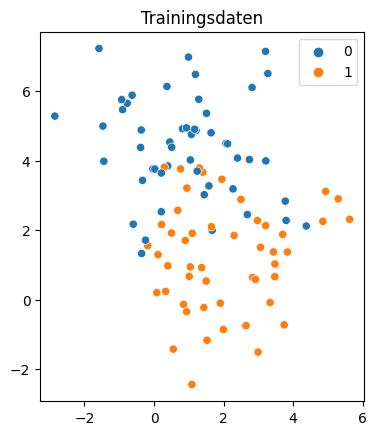

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, legend="full")
plt.title("Trainingsdaten")
plt.gca().set_aspect("equal")
plt.show()

Als nächstes visualisieren wir die Daten für die kein Label existiert. Für diese Daten wollen wir erstmal einen 1-NN Klassifikator schreiben, der sich den nächsten Nachbarn anschaut und ausgehend davon die Klasse eruiert.

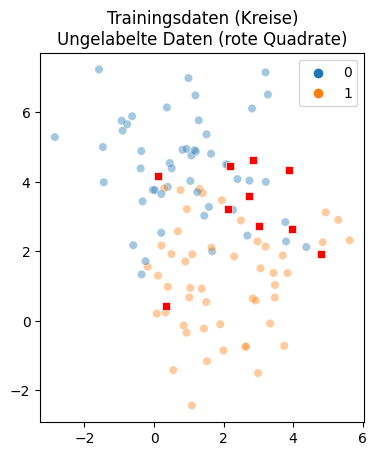

In [4]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, alpha=0.4)
sns.scatterplot(x=U[:,0], y=U[:,1], marker="s", alpha=1.0, color="red")
plt.title("Trainingsdaten (Kreise)\nUngelabelte Daten (rote Quadrate)")
plt.gca().set_aspect("equal")
plt.show()

Die roten Quadrate sind die Punkte, die wir klassifizieren wollen.

# K-Nearest Neighbor mit Python

Wir wollen im folgenden Abschnitt unsere eigene Implementierung in Python schreiben.
Dafür benötigen wir 3 Funktionen:

- `pydistance(x1, x2)`:      Berechnet die euklidische Distanz zweier Punkte `x1` und `x2`. 
- `pynearest(u, X, k=1)`:    Findet den Index der k Punkte im Array `X`, welche den minimalsten Abstand zum Punkt `u` haben.
- `pybatch(U, X, Y)`:  Wendet den k-NN für alle Testdaten in `U` an. Liefert die vorhergesagten Klassenlabels für alle Punkte in `U` zurück.


## Aufgabe 1 - `pydistance`

Schreibe eine Funktion, die für zwei Vektoren $\mathbf{x}$ und $\mathbf{\hat{x}}$ die Euklidische Distanz $D$ ausrechnet und als `float` zurückgibt.
Dabei kann dir die Funktion von `zip()` weiterhelfen.



\begin{align}
\mathbf{x}= \begin{pmatrix}  
x_1 \\ x_2 \\ x_3 \\ ... \\ x_n
\end{pmatrix},
\qquad \mathbf{\hat{x}}=  \begin{pmatrix}  
\hat{x}_1 \\ \hat{x}_2 \\ \hat{x}_3 \\ ... \\ \hat{x}_n
\end{pmatrix} \\ \\
\Longrightarrow D = \sqrt{ (x_1 - \hat{x}_1)^2 + ... + (x_n - \hat{x}_n)^2}
\end{align}

In [5]:
def pydistance(x, x_hat):
    '''
    Rechnet die Euklidiesche Distanz zwischen Punkte x und x_hat aus.
    
    Args:
        x, x_hat (vector-like): Zwei eindimensionale (ndim=1) Vektoren
        
    Returns:
        float: Die Euklidische Distanz
        
    '''
    summe_01 = 0
    
    for i,x in zip(x, x_hat):
        summe_01 += (i - x)**2
        
    d = summe_01**0.5
    
    return d

In [6]:
# Zum Testen

x1, x2 = [1, 2, 3, 2], [3, 2, 1, 2]

print(f"Die Distanz {x1} zu {x1} sollte 0 sein: {pydistance(x1,x1)}")
print(f"Die Distanz {x1} zu {x2} sollte circa 2.82 sein: {pydistance(x1, x2)}")

Die Distanz [1, 2, 3, 2] zu [1, 2, 3, 2] sollte 0 sein: 0.0
Die Distanz [1, 2, 3, 2] zu [3, 2, 1, 2] sollte circa 2.82 sein: 2.8284271247461903


## Aufgabe 2 - `pynearest`

Nachdem wir die Distanzfunktion haben, wollen wir sie auf eine Liste von Vektoren anwenden.
Die Funktion`pynearest` erhält einen ungelabelten Punk $\mathbf{u}$, den wir auf den Trainingsdatensatz klassifizieren wollen. `X` ist die Liste der gelabelten Daten, wobei alle Punkte ein X- und Y-Wert haben.
Das Argument `k` hat einen Default-Wert von 1 und sagt aus, wie viele Nachbarn zurückgeliefert werden sollen.

Erstelle eine Schleife, die durch alle Indizes und Werte in X iteriert, die Distanz zu `u` berechnet und sich für den besten Index entscheidet. 

Starte mit `k=1` und versuche dann den Code auch für höhere `k`-Werte zu implementieren. 

In [7]:
def pynearest(u, X, k = 1):
    '''
    Berechne den Abstand der Punkte aus X zum Punkt u.
    Gib den Index des Punktes aus X mit dem minimalen Abstand zurück.
    
    Args:
        u (vector-like): Der Punkt für den wir eine Aussage machen wollen
        X (list): Eine zweidimensionale Liste vom Trainingsdatensatz
        k (int): Die Anzahl an Nachbarn, die ausgerechnet sollen. Default-Wert ist 1.  
    
    Returns:
        list: Eine Liste der Länge k mit den Index der Datenpunkte aus X mit der minimalsten Distanz zu u.
    '''
    
    knn = []
    for i in X:
        knn.append(pydistance(i, u))
        
    knn_array = np.array(knn)

    return list(knn_array.argsort()[:k])

In [8]:
# Zum Testen des 1-NN

pynearest(X[15], X)  

# Das Ergebnis sollte [15] sein

[15]

In [9]:
# Zum Testen des 3-NN

pynearest(X[15], X, k=3)   

# Aufgrund von dem oben gewählten random_state sollte das Ergebnis hier [15, 0, 72] sein

[15, 0, 72]

## Aufgabe 3 - `pybatch`

Abschließend möchten wir sämtliche Punkte  aus dem Testset `U` klassifizieren. 

Die Funktion `pybatch` berechnet die Vorhersage für alle Punkte in der Liste `U`. Schreibe dafür eine einfache `for`-Schleife, die die Funktion `pynearest` für alle ungelabelte Punkte aufruft. 

Für die k-nächsten Punkte soll dann durch Mehrheitsentscheid das richtige Label zurückgegeben werden. Hierfür ist die Funktion [`mode`](https://docs.python.org/3/library/statistics.html#statistics.mode) aus dem Statistik-Modul von Python sehr praktisch. Diese gibt den häufigsten Wert in einer Liste zurück.

Hier ein kleines Beispiel zu `mode`:


In [16]:
from statistics import mode
#mode([1, 1, 0]), mode([0, 1, 1, 0, 0]), mode([1, 0])

In [17]:
def pybatch(U, X, Y,k=3):
    '''
    Finde für jeden Punkt u aus U den Index für den 
    nächsten Punkt aus X durch Verwendung der Funktion pynearest.
    Lass dir für jeden Punkt u dann das Label dieses Punkte ausgeben.

    Args:
        U (list): Eine Liste mit Punkten, für die wir eine Aussage machen wollen
        X (list): Eine zweidimensionale Liste vom Trainingsdatensatz
        Y (list): Eine Liste mit den Labels für alle Vektoren in X
        k (int): Die Anzahl der Nachbarn die für einen Punkt u aus U in betracht gezogen werden sollen.
        
    Returns:
        list: Eine Liste mit der Vorhersagen für alle Punkte u in U.  
    '''
    u_liste = []
    for u in U:
        u_liste.append(mode(pynearest(u, X, k = 3)))
          
    return u_liste

Über den folgenden Befehl bekommen wir nun die Klassenlabels der Daten Punkte aus `U`:

In [18]:
u_class = pybatch(U, X, Y)

print(u_class)

[35, 38, 69, 83, 72, 67, 35, 1, 44, 94]


Wir können uns das Ergebnis wie oben grafisch anzeigen lassen. Wir können die Quadrate nun mit der richtigen Klassenfarbe im Plot einfärben. Wir sehen, dass die Quadrate die Klasse ihres nächsten Nachbarn haben. Genau das ist der Sinn von 1-NN!

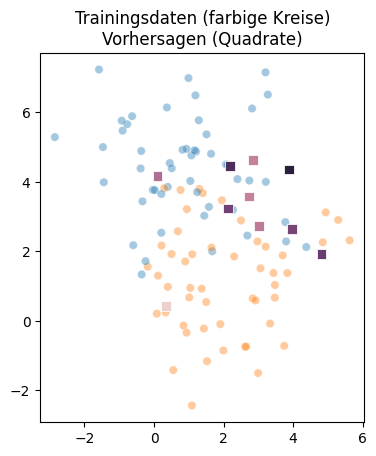

In [19]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, alpha=0.4, legend=None)
sns.scatterplot(x=U[:,0], y=U[:,1], marker="s", s=50, hue=u_class, alpha=1.0, legend=None)
plt.title("Trainingsdaten (farbige Kreise)\nVorhersagen (Quadrate)")
plt.gca().set_aspect("equal")
plt.show()

# K-Nearest Neighbor mit Scikit-learn

## Aufgabe 4 - `sklearn_kNN`

Als letzte Aufgabe wollen wir den Algorithmus mit der Klasse `KNeighborsClassifier` des Moduls <a href=https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html>`sklearn.neighbors`</a> implementieren.

Vervollständige die `for`-Schleife der Funktion `sklearn_kNN`, für die Werte von `k` zwischen 1 und 25, indem du das Modell trainierst und die Vorhersagen für alle Punkte in der Variable `pred` speicherst. 

Wie sehen die Vorhersagen für die 10 Werte in `U` für jeden Wert `k` aus? Merkst du Unterschiede zwischen den Iterationen oder bleibt das Ergebnis konsistent?

In [20]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_kNN(U, X, Y):

    u_class = []
    
    for k in range(1, 26):
        
        clf = KNeighborsClassifier(n_neighbors = k)  
        clf.fit(X, Y)
        pred = clf.predict(U)
              
        u_class.append(pred)
        
        print(k, pred)

    return u_class

1 [0 0 0 0 1 0 0 1 1 0]
2 [0 0 0 0 0 0 0 1 0 0]
3 [0 1 1 0 1 0 0 1 0 0]
4 [0 1 0 0 0 0 0 1 0 0]
5 [0 1 0 0 1 0 0 1 0 0]
6 [0 0 0 0 1 0 0 1 0 0]
7 [0 0 0 0 1 1 0 1 0 0]
8 [0 0 0 0 1 1 0 1 0 0]
9 [0 1 0 0 1 1 0 1 0 0]
10 [0 1 0 0 1 1 0 1 0 0]
11 [0 1 0 0 1 1 0 1 0 0]
12 [0 1 0 0 1 1 0 1 0 0]
13 [0 1 0 0 1 1 0 1 0 0]
14 [0 1 0 0 1 1 0 1 0 0]
15 [0 1 0 0 1 1 0 1 0 0]
16 [0 0 0 0 1 1 0 1 0 0]
17 [0 1 0 0 1 1 0 1 0 0]
18 [0 0 0 0 1 1 0 1 0 0]
19 [0 0 0 0 1 1 0 1 0 0]
20 [0 0 0 0 1 1 0 1 0 0]
21 [0 0 0 0 1 1 0 1 0 0]
22 [0 0 0 0 1 1 0 1 0 0]
23 [0 1 0 0 1 1 0 1 0 0]
24 [0 1 0 0 1 1 0 1 0 0]
25 [0 1 0 0 1 1 0 1 0 0]


Text(0.5, 0.98, 'Trainingsdaten & Vorhersagen')

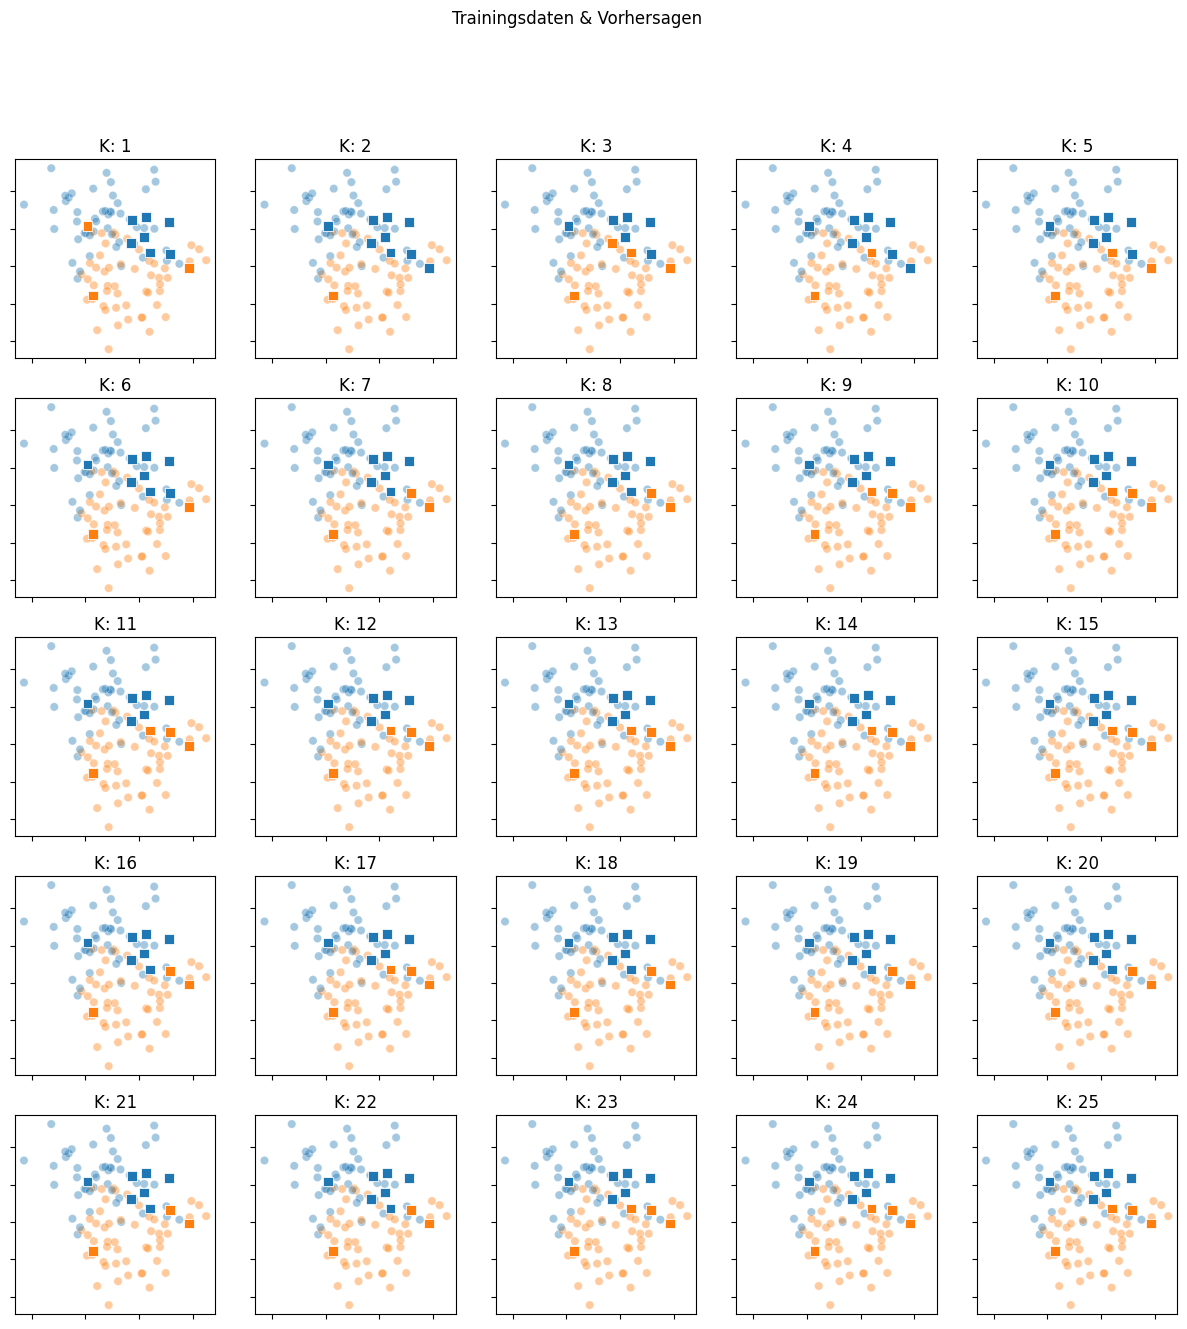

In [21]:
U, X, Y = toy(10, 100, 2)

u_class = sklearn_kNN(U, X, Y)

fig, axis = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)

k = 0
for i in range(5):
    for j in range(5):
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, alpha=0.4, legend=None, ax=axis[i,j])
        sns.scatterplot(x=U[:,0], y=U[:,1], marker="s", s=50, hue=u_class[k], alpha=1.0, ax=axis[i,j], legend=None)
        k += 1
        axis[i,j].set(title=f"K: {k}", xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
        
plt.suptitle("Trainingsdaten & Vorhersagen")

In [ ]:
# ab k 9 bis k 15 pendelt es sich ein, vorher Schwankungen, ab k 16 wieder Schwankungen